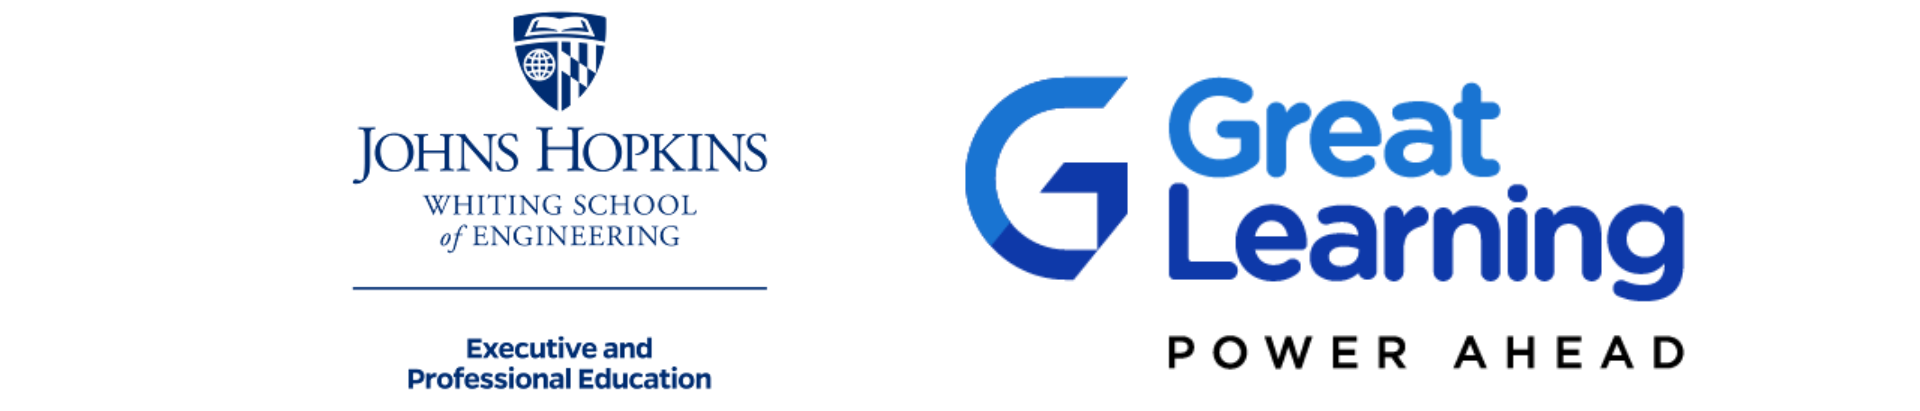

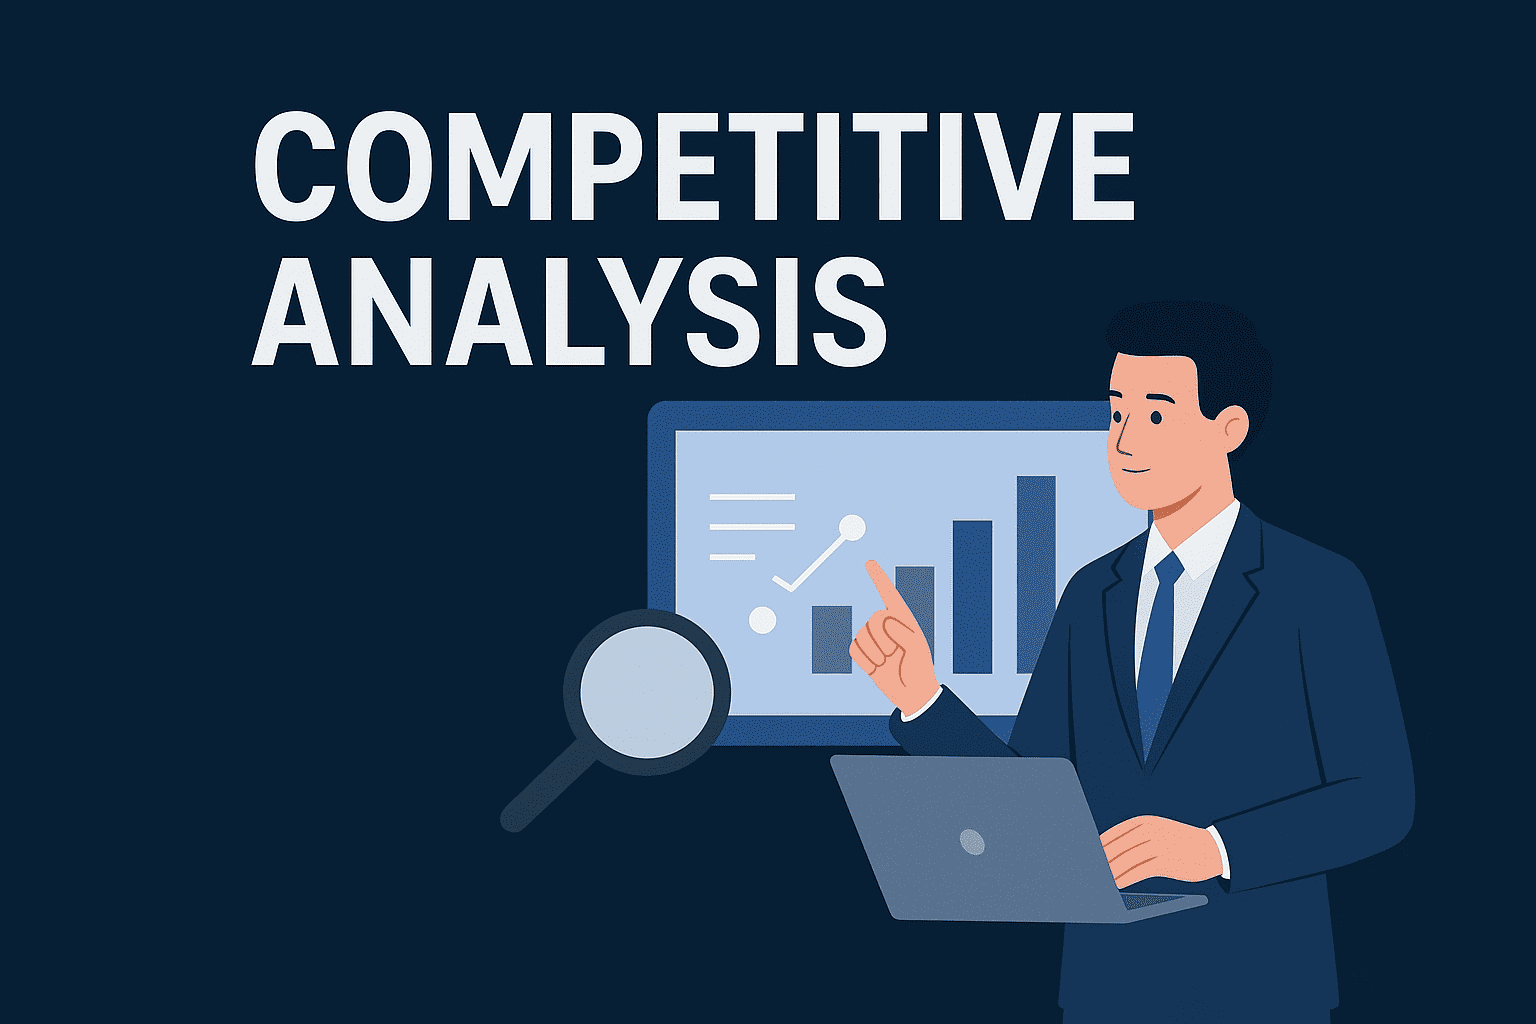

# Learning Objectives

- Implement **Model Context Protocol(MCP**) powered AI Agent System capable of autonomous planning and reasoning to achieve specified objectives.



# Business Case: Competitive Analysis

## Problem Scenario

In today's fast-paced and highly competitive business landscape, staying ahead of competitors is critical for any organization aiming to maintain or grow its market position. Conducting thorough competitive analysis to understand market scenarios, competitor strategies, and emerging opportunities is essential. However, this analysis is a complex, time-intensive process requiring up-to-date knowledge of industry trends and competitors performance.

## Proposed Solution

To address the mentioned challenges, a Competitive Analysis AI Agent is proposed. This single-agent system will simulate the analysis of the strategies of the top three competitors for a given company and perform market research through integrated tools, such as web search. It validates the input company, identifies its sector, and determines key competitor companies within that sector. The agent then collects and analyzes strategic data (e.g., pricing, marketing, and product offerings) about these competitor companies, and finally delivers a comparative report with actionable insights to help the company outperform its competitors.

## Solution Approach

The implemented solution is an AI agent leveraging MCP's client-server architecture. The MCP server hosts tools for company validation, sector identification, competitor identification, browsing, and report generation. The single agent system runs on the client side and accesses the tools hosted on the server using MCP (as depicted below).


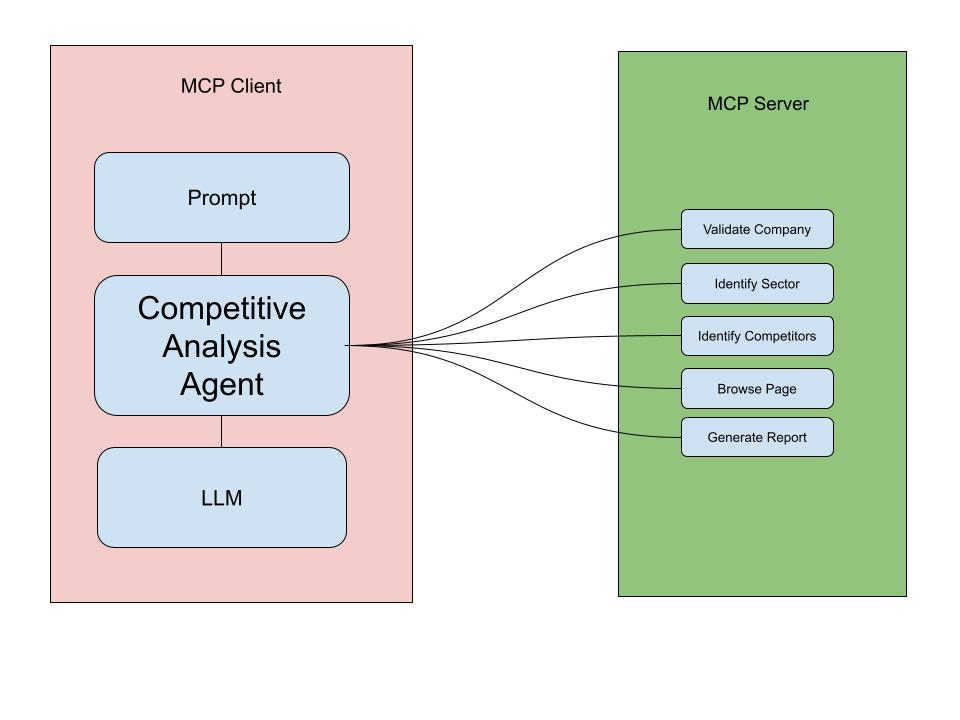

In [ ]:
! pip install -q openai==1.101.0 \
                 smolagents[toolkit]==1.21.2 \
                 smolagents[mcp]==1.21.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 810.8/810.8 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.4/145.4 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 47.4 MB/s eta 0:00:00


# MCP-Server Setup

FastMCP server class is needed for the MCP server implementation.

In [ ]:
import re
import threading
import time
from collections import Counter
import requests
from bs4 import BeautifulSoup
from mcp.server.fastmcp import FastMCP

### Initialize Server

Initializing the FastMCP server instance below, and configuring it with a name ('demo'), hostname ('localhost'), and port.

In [ ]:
# Create an MCP server
mcp = FastMCP(
    "demo",
    host="127.0.0.1",
    port=8000
)

## Server Tools

Defining custom tools below for, validating company names, identifying sectors, finding competitors, browsing web pages for gathering competitive data, and generating report. Note that each tool uses the `@mcp.tool()` decorator. Also, error handling is included for robustness.

### Tool 1 : Validate Company

This tool validates whether a given company name corresponds to a real business by performing a web search and analyzing signals such as official domains, site mentions, business terminology, and reputable sources. It returns a clear validation result with evidence derived from search data.


In [ ]:
@mcp.tool()
def validate_company(company_name: str) -> str:
    """
    Validate if the input company name corresponds to a real company using web search.
    Args:
        company_name (str): The name of the company to validate.
    Returns:
        str: Validation result with evidence from search results.
    """
    print(f"[INSIDE TOOL]: validate_company - searching for '{company_name}'")

    try:
        # Perform web search for the company
        search_query = f"{company_name} company business official site"
        results = web_search_tool(search_query)

        # Analyze search results for company evidence
        if is_company_valid_based_on_search(results, company_name):
            return f"[ VALID COMPANY ]: {company_name} (verified via web search)"
        else:
            return f"[NOT valid company]: No substantial evidence found for '{company_name}'"

    except Exception as e:
        return f"Validation failed: {str(e)}"

def is_company_valid_based_on_search(search_results: str, company_name: str) -> bool:
    """Analyze search results to determine if company is valid"""

    # Convert to lowercase for case-insensitive matching
    results_lower = search_results.lower()
    company_lower = company_name.lower()

    # Evidence indicators
    evidence_count = 0

    # Check for official website patterns
    if f"{company_lower}.com" in results_lower:
        evidence_count += 1
        print(f"Found official domain: {company_lower}.com")

    # Check for "official site" mentions
    if "official site" in results_lower or "official website" in results_lower:
        evidence_count += 1
        print("Found official site mention")

    # Check for company description patterns
    if "company" in results_lower and company_lower in results_lower:
        evidence_count += 1
        print("Found company description")

    # Check for business-related terms
    business_terms = ["corporation", "inc", "ltd", "llc", "business", "enterprise"]
    if any(term in results_lower for term in business_terms):
        evidence_count += 1
        print("Found business terminology")

    # Check for news or Wikipedia mentions
    if "wikipedia" in results_lower or "news" in results_lower:
        evidence_count += 1
        print("Found Wikipedia or news mentions")

    print(f"Total evidence points: {evidence_count}")
    return evidence_count >= 2

### Tool 2 : Identify Sector

This tool identifies a company’s industry sector using multi-stage web search analysis. It extracts sector indicators from descriptions, profiles, and financial contexts, then determines the most likely sector using weighted evidence. The result includes a confidence-based sector selection.


In [ ]:
@mcp.tool()
def identify_sector(company_name: str) -> str:
    """
    Determine industry sector using multiple search strategies.
    Args:
        company_name (str): The name of the company.
    Returns:
        str: The sector with confidence indicator.
    """
    print(f"[INSIDE TOOL]: identify_sector - comprehensive analysis for '{company_name}'")

    try:
        all_sectors = []

        # Strategy 1: General company description search
        results1 = web_search_tool(f"what does {company_name} do business industry")
        sectors1 = extract_sectors_advanced(results1, company_name)
        all_sectors.extend(sectors1)

        time.sleep(1)  # Rate limit respect

        # Strategy 2: Wikipedia/LinkedIn style search
        results2 = web_search_tool(f"{company_name} wikipedia linkedin industry type")
        sectors2 = extract_sectors_advanced(results2, company_name)
        all_sectors.extend(sectors2)

        time.sleep(1)

        # Strategy 3: News and financial context
        results3 = web_search_tool(f"{company_name} news financial reports sector")
        sectors3 = extract_sectors_advanced(results3, company_name)
        all_sectors.extend(sectors3)

        # Determine final sector
        final_sector = determine_primary_sector(all_sectors)

        return final_sector if final_sector else "Unknown sector"

    except Exception as e:
        return f"Error identifying sector: {str(e)}"

def extract_sectors_advanced(search_results: str, company_name: str) -> list:
    """Advanced sector extraction with context analysis"""

    results_lower = search_results.lower()
    company_lower = company_name.lower()

    # Extended sector definitions with weighted keywords
    sector_patterns = {
        "Technology": {
            "keywords": ["technology", "software", "hardware", "saas", "cloud", "ai", "artificial intelligence"],
            "weight": 1.0
        },
        "Finance": {
            "keywords": ["financial", "banking", "investment", "fintech", "insurance", "bank"],
            "weight": 1.0
        },
        "Healthcare": {
            "keywords": ["healthcare", "medical", "pharmaceutical", "biotech", "hospital", "health"],
            "weight": 1.0
        },
        "Education": {
            "keywords": ["education", "edtech", "e-learning", "online learning", "educational"],
            "weight": 1.0
        },
        "Retail": {
            "keywords": ["retail", "e-commerce", "online shopping", "marketplace" ],
            "weight": 1.0
        },
        "Manufacturing": {
            "keywords": ["manufacturing", "industrial", "automotive", "electronics", "factory"],
            "weight": 1.0
        },
        "Energy": {
            "keywords": ["energy", "renewable", "oil and gas", "solar" ],
            "weight": 1.0
        }
    }

    found_sectors = []

    # Check for explicit sector mentions
    for sector, pattern in sector_patterns.items():
        for keyword in pattern["keywords"]:
            if keyword in results_lower:
                # Check if this appears to be in context of the company
                if (company_lower in results_lower or
                    any(phrase in results_lower for phrase in [f"is a {keyword}", f"in the {keyword}"])):
                    found_sectors.extend([sector] * int(pattern["weight"] * 2))
                else:
                    found_sectors.extend([sector] * int(pattern["weight"]))

    return found_sectors

def determine_primary_sector(sectors_list: list) -> str:
    """Determine primary sector from list of found sectors"""
    if not sectors_list:
        return ""

    sector_counts = Counter(sectors_list)
    most_common = sector_counts.most_common(1)[0]

    # Only return if we have reasonable confidence
    if most_common[1] >= 2:  # At least 2 mentions
        return most_common[0]
    elif len(sector_counts) == 1 and most_common[1] >= 1:
        return most_common[0]

    return ""

### Tool 3 : Identify Competitors

This tool identifies the top competitors of a company by analyzing sector-specific web search results. It extracts and ranks competitor names using pattern matching, sector knowledge, and frequency analysis, returning the top three most relevant rivals.


In [ ]:
@mcp.tool()
def identify_competitors(sector: str, company_name: str) -> str:
    """
    Identify top 3 competitors using comprehensive web search analysis.
    Args:
        sector (str): The industry sector.
        company_name (str): The name of the company to exclude.
    Returns:
        str: Comma-separated list of top 3 competitors.
    """
    print(f"[INSIDE TOOL]: identify_competitors - analyzing '{sector}' sector excluding '{company_name}'")

    try:
        competitor_candidates = []

        # Query 1: General sector competitors
        results1 = web_search_tool(f"top {sector} companies competitors market share")
        candidates1 = extract_competitors_advanced(results1, company_name, sector)
        competitor_candidates.extend(candidates1)

        time.sleep(1)  # Rate limiting

        # Query 2: Direct competitors of the company
        results2 = web_search_tool(f"who are {company_name} main competitors in {sector}")
        candidates2 = extract_competitors_advanced(results2, company_name, sector)
        competitor_candidates.extend(candidates2)

        time.sleep(1)

        # Query 3: Industry analysis
        results3 = web_search_tool(f"{sector} industry key players leading companies")
        candidates3 = extract_competitors_advanced(results3, company_name, sector)
        competitor_candidates.extend(candidates3)

        # Filter and rank competitors
        final_competitors = rank_competitors(competitor_candidates, company_name)

        if final_competitors:
            top_3 = final_competitors[:3]
            return ", ".join(top_3)
        else:
            return "No competitors identified"

    except Exception as e:
        return f"Error identifying competitors: {str(e)}"

def extract_competitors_advanced(search_results: str, exclude_company: str, sector: str) -> list:
    """Advanced competitor extraction with context awareness"""

    exclude_lower = exclude_company.lower()
    sector_lower = sector.lower()
    results_lower = search_results.lower()

    competitors = []

    # Known company patterns in different sectors
    sector_companies = {
        "technology": ["microsoft", "apple", "amazon", "meta", "google", "ibm", "oracle", "intel"],
        "finance": ["jpmorgan", "bank of america", "goldman sachs", "morgan stanley", "citi", "wells fargo"],
        "healthcare": ["johnson & johnson", "pfizer", "merck", "novartis", "roche", "abbvie"],
        "education": ["great learning", "coursera", "udemy", "edx", "khan academy", "byju's", "pluralsight"],
        "retail": ["walmart", "target", "amazon", "home depot", "costco", "best buy"],
        "automotive": ["toyota", "ford", "general motors", "honda", "bmw", "mercedes-benz"]
    }

    # Look for known companies in this sector
    if sector_lower in sector_companies:
        for company in sector_companies[sector_lower]:
            if (company in results_lower and
                company != exclude_lower and
                company not in competitors):
                competitors.append(company.title())

    # Extract from list patterns
    list_patterns = [
        r'(?:competitors|companies|players):? ([^\.]+)',
        r'(?:including|such as) ([^\.]+)',
        r'top \d+ ([^:]+) companies',
    ]

    for pattern in list_patterns:
        matches = re.findall(pattern, search_results, re.IGNORECASE)
        for match in matches:
            # Split and clean potential company names
            potential_companies = re.split(r',|\band\b|\bor\b|;', match)
            for comp in potential_companies:
                comp = comp.strip()
                if (is_likely_company_name(comp) and
                    comp.lower() != exclude_lower and
                    comp not in competitors):
                    competitors.append(comp)

    # Extract from numbered/bulleted lists
    numbered_pattern = r'\b\d+\.\s*([A-Z][a-zA-Z\s&]+?)(?=\.|\n|$)'
    matches = re.findall(numbered_pattern, search_results)
    for match in matches:
        comp = match.strip()
        if (is_likely_company_name(comp) and
            comp.lower() != exclude_lower and
            comp not in competitors):
            competitors.append(comp)

    return competitors

def is_likely_company_name(text: str) -> bool:
    """Check if text looks like a company name"""
    if not text or len(text) < 2:
        return False

    # Exclude common non-company words
    non_company_words = {
        'the', 'and', 'or', 'but', 'with', 'for', 'from', 'that', 'this',
        'these', 'those', 'their', 'other', 'some', 'such', 'including',
        'etc', 'etc.', 'among', 'various', 'several', 'many'
    }

    words = text.lower().split()
    if any(word in non_company_words for word in words):
        return False

    # Should start with capital letter and have reasonable length
    return (text[0].isupper() and
            len(text) <= 50 and
            any(c.isalpha() for c in text))

def rank_competitors(competitor_candidates: list, exclude_company: str) -> list:
    """Rank competitors by frequency and relevance"""
    if not competitor_candidates:
        return []

    exclude_lower = exclude_company.lower()

    # Filter out the excluded company and clean the list
    filtered_competitors = [
        comp for comp in competitor_candidates
        if comp.lower() != exclude_lower and comp.strip()
    ]

    if not filtered_competitors:
        return []

    # Count occurrences and return most frequent
    competitor_counts = Counter(filtered_competitors)
    return [comp for comp, count in competitor_counts.most_common()]

### Tool 4 : Browse Page

This tool scrapes a webpage and extracts information based on user-defined instructions. It fetches page content, cleans irrelevant elements, and returns the most relevant text using keyword-based sentence matching.  


In [ ]:
@mcp.tool()
def browse_page(url: str, instructions: str) -> str:
    """
    Browse a webpage and extract information based on instructions using web scraping.
    Args:
        url (str): The URL to browse.
        instructions (str): Instructions for what information to extract.
    Returns:
        str: Extracted information or error message.
    """
    print(f"[INSIDE TOOL]: browse_page - scraping {url} for '{instructions}'")

    try:
        # Validate and prepare URL
        if not url.startswith(('http://', 'https://')):
            url = 'https://' + url

        # Fetch webpage content
        content = fetch_webpage_content(url)
        if not content:
            return f"Failed to fetch content from {url}"

        # Extract relevant text based on instructions
        extracted_text = extract_relevant_content(content, instructions)

        return extracted_text if extracted_text else "No relevant content found based on the instructions"

    except Exception as e:
        return f"Error browsing page: {str(e)}"

def fetch_webpage_content(url: str) -> str:
    """Fetch webpage content with proper headers"""
    try:
        headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36',
            'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
        }

        response = requests.get(url, headers=headers, timeout=10)
        response.raise_for_status()

        # Parse HTML and extract main text content
        soup = BeautifulSoup(response.content, 'html.parser')

        # Remove script and style elements
        for script in soup(["script", "style", "nav", "footer", "header"]):
            script.decompose()

        # Get text from main content areas
        main_content = soup.find_all(['main', 'article', 'div', 'p'])
        text_parts = []

        for element in main_content:
            text = element.get_text(strip=True)
            if text and len(text) > 20:  # Only include substantial text
                text_parts.append(text)

        return ' '.join(text_parts[:5000])  # Limit length

    except Exception as e:
        print(f"Error fetching {url}: {e}")
        return None

def extract_relevant_content(content: str, instructions: str) -> str:
    """Extract content relevant to the instructions"""
    content_lower = content.lower()
    instructions_lower = instructions.lower()

    # Split content into sentences for better matching
    sentences = [s.strip() for s in content.split('.') if s.strip()]

    relevant_sentences = []

    # Simple keyword matching based on instructions
    for sentence in sentences:
        sentence_lower = sentence.lower()

        # Check if sentence contains words from instructions
        instruction_words = set(instructions_lower.split())
        sentence_words = set(sentence_lower.split())

        # Count matching words
        matching_words = instruction_words.intersection(sentence_words)

        # If substantial match, include the sentence
        if len(matching_words) >= 1 and len(sentence) > 10:
            relevant_sentences.append(sentence)

    # If no specific matches found, return first few sentences as summary
    if not relevant_sentences and sentences:
        return '. '.join(sentences[:5]) + '...'

    return '. '.join(relevant_sentences[:10])  # Limit to top 10 relevant sentences

### Tool 5 : Generate Report

This tool generates a structured competitive analysis report for a given company using context gathered from earlier tools. It extracts competitor names dynamically, builds a comparison table, and assembles a formatted report without any LLM calls. The report includes a summary, competitor table, and actionable strategic insights.  



In [ ]:
@mcp.tool()
def generate_report(company_name: str, context: str) -> str:
    """
    Generate a competitive analysis report with a comparison table and actionable insights for the input company.
    Args:
        company_name: The name of the company to analyze.
        context: Retrieved context from tools.
    Returns:
        str: Formatted report.
    """
    print("[INSIDE TOOL]: generate_report")

    # Parse competitors from context instead of using static placeholders
    competitors = extract_competitors_from_context(context)

    # Build dynamic competitor rows
    competitor_rows = ""
    for i, competitor in enumerate(competitors[:3]):  # Top 3 competitors
        competitor_rows += f"| {competitor} | - | - | - | - |\n"

    # If no competitors found, use placeholders but indicate this
    if not competitor_rows:
        competitor_rows = "| Competitor A | - | - | - | - |\n| Competitor B | - | - | - | - |\n| Competitor C | - | - | - | - |"

    # Simple template-based report (NO LLM calls) with dynamic data
    report_template = f"""
# Competitive Analysis Report: {company_name}

## Executive Summary
Analysis of {company_name}'s competitive position based on available market data.

## Competitor Comparison

| Competitor | Strategy Type | Key Tactics | Strengths | Weaknesses |
|------------|---------------|-------------|-----------|------------|
{competitor_rows}

## Actionable Insights for {company_name}
- Develop differentiated positioning in the market
- Focus on unique value propositions
- Optimize operational efficiencies
- Enhance customer engagement strategies

*Report generated from context data. Fill in specific details based on comprehensive market research.*
"""

    return report_template.strip()

def extract_competitors_from_context(context: str) -> list:
    """Extract competitor names from context string"""
    competitors = []

    # Look for comma-separated competitor lists
    if ", " in context:
        potential_competitors = context.split(", ")
        for comp in potential_competitors:
            if comp and len(comp) > 2 and comp[0].isupper():
                competitors.append(comp)

    # Look for known competitor patterns
    import re
    competitor_patterns = [
        r'competitors?[:\s]+([^\.\n]+)',
        r'top.*companies?[:\s]+([^\.\n]+)',
    ]

    for pattern in competitor_patterns:
        matches = re.findall(pattern, context, re.IGNORECASE)
        for match in matches:
            # Split by common separators
            found_comps = re.split(r',|\band\b', match)
            competitors.extend([comp.strip() for comp in found_comps if comp.strip()])

    return list(set(competitors))[:5]  # Remove duplicates and limit

## Start Server

###Introduction to the MCP Server

The Model Context Protocol (MCP) server acts as a powerful bridge between AI models and external tools, data sources, or system capabilities. Instead of manually wiring integrations, the MCP server exposes structured, callable tools that an AI agent can use dynamically at runtime. By running as a lightweight service, it enables seamless interaction through standardized requests - whether for web search, data extraction, analysis, or custom workflows. This architecture not only simplifies tool integration but also ensures scalability, modularity, and clean separation between AI logic and operational functions.

---
###FastMCP
FastMCP is a streamlined, high-performance implementation of the Model Context Protocol designed for rapid tool execution and minimal overhead. It provides a lightweight infrastructure that can spin up MCP servers quickly, handle concurrent requests efficiently, and integrate tools with near-instant responsiveness. By reducing boilerplate and optimizing transport handling, FastMCP enables developers to build flexible AI-tooling pipelines with far less friction. Its speed and simplicity make it ideal for real-time analysis, interactive agents, and production-grade AI workflows.

For more details: https://gofastmcp.com/getting-started/welcome

---

This code starts the MCP server in a separate background thread, allowing it to run without blocking the main application. It uses the `streamable-http` transport for handling incoming requests efficiently. A short delay ensures the server has time to initialize before the program proceeds. Finally, it prints a confirmation message indicating the server is live at `http://127.0.0.1:8000/mcp`.  


In [ ]:
# Start the MCP server in a background thread
def start_mcp_server():
    mcp.run(transport="streamable-http")

server_thread = threading.Thread(target=start_mcp_server, daemon=True)
server_thread.start()

# Brief pause to allow the server to fully start
time.sleep(3)
print("MCP server started on http://127.0.0.1:8000/mcp")

INFO:     Started server process [222]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)


MCP server started on http://127.0.0.1:8000/mcp


# MCP-Client Setup

Setting up the client-side AI agent using the smolagent library.

### Imports

In [ ]:
import os
from google.colab import userdata
from smolagents import (
    OpenAIServerModel,
    MCPClient,
    CodeAgent,
    DuckDuckGoSearchTool,
    ToolCallingAgent,
    tool,
    PromptTemplates,
    PlanningPromptTemplate,
    ManagedAgentPromptTemplate,
    FinalAnswerPromptTemplate,
)

In [ ]:
# Set environment variables
openai_api_key = userdata.get('openai_api_key')
os.environ["OPENAI_API_KEY"] = openai_api_key
os.environ['OPENAI_BASE_URL'] = "https://aibe.mygreatlearning.com/openai/v1"

### LLM

In [ ]:
# LLM Setup - Using the "gpt-4o-mini" model as LLM
model = OpenAIServerModel(model_id="gpt-4o-mini")

### Prompt Setup

This configuration defines a complete prompt framework for a Competitive Analysis Agent using structured templates.  
The `system_prompt` establishes the agent’s role and outlines core tasks - validating the company, identifying its sector, finding competitors, gathering strategic data, and producing a focused competitive analysis.  

`Planning_prompts` guide the agent through step-by-step workflows, updating facts and plans as new information is discovered while keeping the analysis centered on one company.  

`Managed_agent` and `final_answer` templates ensure that the resulting report is well-formatted, insight-driven, and tailored specifically to helping the input company outperform its top three competitors.  


In [ ]:
system_prompt = (
    """
    You are an expert Competitive Analysis Agent. Given a single company name, perform the following tasks:
    - Validate that it is a real company using available validation tools or web search.
    - Determine its primary industry sector using sector identification tools or web search.
    - Identify its top three competitors (excluding the company itself) using competitor discovery tools or web search.
    - Gather real-time strategy data—such as pricing, marketing, product offerings, recent quarterly earnings reports, press releases, and authentic news articles—accessible on websites using browsing or search tools.
    Analyze the collected data to compare strategies and generate a formatted report with actionable insights to help the input company outperform its competitors. Focus exclusively on the provided company and its top three competitors; do not expand to additional entities.
    """
)

planning_prompts = PlanningPromptTemplate(
    initial_facts=(
        """
        Key facts about the input company and its top three competitors from initial research:
        {facts}
        """
    ),
    initial_plan=(
        """
        Step-by-step plan:
        1. Validate the single input company name.
        2. Determine the sector for the input company.
        3. Identify the top 3 competitors for the input company.
        4. Gather strategy data on the input company and its top 3 competitors.
        5. Analyze strategies and generate a comparison table.
        6. Propose actionable insights for the input company.
        """
    ),
    update_facts_pre_messages="Reassess facts with new information, focusing on the input company and its competitors:",
    update_facts_post_messages="Updated facts considered for the single-company analysis.",
    update_plan_pre_messages="Revise the analysis plan based on new data, maintaining focus on one company:",
    update_plan_post_messages="Analysis plan revised for targeted competitive insights."
)

managed_agent_prompts = ManagedAgentPromptTemplate(
    task="""
    Your task is to analyze the strategies of the top 3 competitors relative to the single input company {task_description} and
    produce a comparison table with actionable insights tailored to helping {task_description} outperform them.
    """,
    report="Generate a detailed, focused report based on the task results for {task_description}: {results}"
)

final_answer_prompts = FinalAnswerPromptTemplate(
    pre_messages="""
    Based on the analysis of the input company and its top three competitors,
    prepare a beautifully formatted report with a comparison table and actionable insights to drive competitive advantage.
    """,
    post_messages="Ensure the response is clear, concise, professionally presented, and centered on the single input company.",
    final_answer_template=(
        """
        Provide a Markdown report for the input company with sections:
        Executive Summary (overview of competitive position),
        Comparison Table (strategies across the input company and top 3 competitors),
        Actionable Insights (specific recommendations to outperform competitors).
        """
    )
)


prompt_templates = PromptTemplates(
    system_prompt=system_prompt,
    planning=planning_prompts,
    managed_agent=managed_agent_prompts,
    final_answer=final_answer_prompts
)

## Built-in Tool

The built-in DuckDuckGo web search tool will be leveraged for web search to help in the agent's research work.

In [ ]:
# Initialize search tool once
web_search_tool = DuckDuckGoSearchTool(max_results=5, rate_limit=2.0)

# MCP Client-Server Connect

This code creates an MCP client connected to the local MCP server using the `streamable-http` transport. It initializes a `ToolCallingAgent` with the available tools, model, and predefined prompt templates. The agent is then configured to include base tools for broader functionality. Finally, it runs a competitive analysis workflow by passing the company name “Amazon” to the agent.  


In [ ]:
with MCPClient({"url": "http://127.0.0.1:8000/mcp", "transport": "streamable-http"}) as tools:
    competitive_analysis_agent  = ToolCallingAgent(tools=tools, model=model,
    add_base_tools=True,
    prompt_templates=prompt_templates)
    result = competitive_analysis_agent.run("Amazon")

INFO:     127.0.0.1:38328 - "POST /mcp HTTP/1.1" 200 OK
INFO:     127.0.0.1:38342 - "POST /mcp HTTP/1.1" 202 Accepted
INFO:     127.0.0.1:38350 - "GET /mcp HTTP/1.1" 200 OK
INFO:     127.0.0.1:38354 - "POST /mcp HTTP/1.1" 200 OK
INFO:     127.0.0.1:38360 - "POST /mcp HTTP/1.1" 200 OK


╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ Amazon                                                                                                          │
│                                                                                                                 │
╰─ OpenAIServerModel - gpt-4o-mini ───────────────────────────────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Calling tool: 'validate_company' with arguments: {'company_name': 'Amazon'}                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Calling tool: 'identify_sector' with arguments: {'company_name': 'Amazon'}                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

INFO:     127.0.0.1:60372 - "POST /mcp HTTP/1.1" 200 OK
[INSIDE TOOL]: validate_company - searching for 'Amazon'
Found official domain: amazon.com
Found company description
Found business terminology
Found Wikipedia or news mentions
Total evidence points: 4
INFO:     127.0.0.1:60378 - "POST /mcp HTTP/1.1" 200 OK
[INSIDE TOOL]: identify_sector - comprehensive analysis for 'Amazon'


Observations: | VALID COMPANY ]: Amazon (verified via web search)

Observations: Technology

[Step 1: Duration 9.91 seconds| Input tokens: 779 | Output tokens: 47]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 2 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Calling tool: 'identify_competitors' with arguments: {'sector': 'Technology', 'company_name': 'Amazon'}         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

INFO:     127.0.0.1:48938 - "POST /mcp HTTP/1.1" 200 OK
[INSIDE TOOL]: identify_competitors - analyzing 'Technology' sector excluding 'Amazon'


Observations: AppSumo, Apple, Google

[Step 2: Duration 7.00 seconds| Input tokens: 1,685 | Output tokens: 69]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 3 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Calling tool: 'browse_page' with arguments: {'url': 'https://www.apple.com', 'instructions': 'Extract pricing,  │
│ marketing strategies, and product offerings.'}                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Calling tool: 'browse_page' with arguments: {'url': 'https://www.appsumo.com', 'instructions': 'Extract         │
│ pricing, marketing strategies, and product offerings.'}                                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Calling tool: 'browse_page' with arguments: {'url': 'https://www.google.com', 'instructions': 'Extract pricing, │
│ marketing strategies, and product offerings.'}                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

INFO:     127.0.0.1:48942 - "POST /mcp HTTP/1.1" 200 OK
[INSIDE TOOL]: browse_page - scraping https://www.apple.com for 'Extract pricing, marketing strategies, and product offerings.'
INFO:     127.0.0.1:48956 - "POST /mcp HTTP/1.1" 200 OK
INFO:     127.0.0.1:48960 - "POST /mcp HTTP/1.1" 200 OK
[INSIDE TOOL]: browse_page - scraping https://www.appsumo.com for 'Extract pricing, marketing strategies, and product offerings.'


Observations: Learn moreBuyiPadNow with the speed of the A16 chip and double the starting storage. Learn moreApply 
nowApply nowApple TVFAM GalleryWatch nowStrong and Calm Combos for Busy DaysListen nowSeth Rogen: The Zane Lowe 
InterviewPlay nowPGA TOUR Pro GolfWatch nowStrength with GreggListen nowA-List PopPlay nowBalatro+ Give something 
special. iPadNow with the speed of the A16 chip and double the starting storage. Learn moreBuy iPadNow with the 
speed of the A16 chip and double the starting storage. Learn moreBuy iPadNow with the speed of the A16 chip and 
double the starting storage. Learn moreBuy iPadNow with the speed of the A16 chip and double the starting storage. 
Learn moreBuy Now with the speed of the A16 chip and double the starting storage. Learn moreApply nowApply now FAM 
GalleryWatch nowStrong and Calm Combos for Busy DaysListen nowSeth Rogen: The Zane Lowe InterviewPlay nowPGA TOUR 
Pro GolfWatch nowStrength with GreggListen nowA-List PopPlay nowBalatro+ FAM GalleryWatch nowStrong and Calm Combos
for Busy DaysListen nowSeth Rogen: The Zane Lowe InterviewPlay nowPGA TOUR Pro GolfWatch nowStrength with 
GreggListen nowA-List PopPlay nowBalatro+ Watch nowStrong and Calm Combos for Busy DaysListen nowSeth Rogen: The 
Zane Lowe InterviewPlay nowPGA TOUR Pro GolfWatch nowStrength with GreggListen nowA-List PopPlay nowBalatro+ Watch 
nowStrong and Calm Combos for Busy Days Strong and Calm Combos for Busy Days Strong and Calm Combos for Busy Days 
Listen nowSeth Rogen: The Zane Lowe Interview Seth Rogen: The Zane Lowe Interview Seth Rogen: The Zane Lowe 
Interview Play nowPGA TOUR Pro Golf Watch nowStrength with Gregg

[INSIDE TOOL]: browse_page - scraping https://www.google.com for 'Extract pricing, marketing strategies, and product offerings.'


Observations: 8 rating on Google*Shop Black Friday DealsView allGumlet VideoPrice increases in 6 daysGumlet 
VideoinVideoHost, secure, and stream videos with a personalized player in 
minutes116reviews$69/lifetime$300SubscribrPrice increases in 6 daysSubscribrinVideoCreate long-form YouTube scripts
with hooks and storytelling techniques designed to go viral103reviews$69/lifetime$84DepositPhotosPrice increases in
6 daysDepositPhotosinStock photosAccess millions of royalty-free stock assets using this content library and 
generative AI tool538reviews$39/lifetime$300reapPrice increases in 6 daysreapinVideoRepurpose long videos with an 
AI video editor that clips, captions, dubs, and publishes in minutes51reviews$69/lifetime$1,740PhotoGPT AIPrice 
increases in 6 daysPhotoGPT AIinContent marketingTrain an AI model on your photos to generate realistic headshots, 
creative portraits, and styled images59reviews$69/lifetime$87PreviousNext Next drop 
in00DAYS00HOURS00MINUTES00SECONDSBlack Friday is here! Create viral videos + stunning visuals with our first tool 
drop. 8 rating on Google*Shop Black Friday DealsView allGumlet VideoPrice increases in 6 daysGumlet 
VideoinVideoHost, secure, and stream videos with a personalized player in 
minutes116reviews$69/lifetime$300SubscribrPrice increases in 6 daysSubscribrinVideoCreate long-form YouTube scripts
with hooks and storytelling techniques designed to go viral103reviews$69/lifetime$84DepositPhotosPrice increases in
6 daysDepositPhotosinStock photosAccess millions of royalty-free stock assets using this content library and 
generative AI tool538reviews$39/lifetime$300reapPrice increases in 6 daysreapinVideoRepurpose long videos with an 
AI video editor that clips, captions, dubs, and publishes in minutes51reviews$69/lifetime$1,740PhotoGPT AIPrice 
increases in 6 daysPhotoGPT AIinContent marketingTrain an AI model on your photos to generate realistic headshots, 
creative portraits, and styled images59reviews$69/lifetime$87PreviousNext Next drop 
in00DAYS00HOURS00MINUTES00SECONDSBlack Friday is here! Create viral videos + stunning visuals with our first tool 
drop. 8 rating on Google*Shop Black Friday DealsView allGumlet VideoPrice increases in 6 daysGumlet 
VideoinVideoHost, secure, and stream videos with a personalized player in 
minutes116reviews$69/lifetime$300SubscribrPrice increases in 6 daysSubscribrinVideoCreate long-form YouTube scripts
with hooks and storytelling techniques designed to go viral103reviews$69/lifetime$84DepositPhotosPrice increases in
6 daysDepositPhotosinStock photosAccess millions of royalty-free stock assets using this content library and 
generative AI tool538reviews$39/lifetime$300reapPrice increases in 6 daysreapinVideoRepurpose long videos with an 
AI video editor that clips, captions, dubs, and publishes in minutes51reviews$69/lifetime$1,740PhotoGPT AIPrice 
increases in 6 daysPhotoGPT AIinContent marketingTrain an AI model on your photos to generate realistic headshots, 
creative portraits, and styled images59reviews$69/lifetime$87PreviousNext Next drop 
in00DAYS00HOURS00MINUTES00SECONDSBlack Friday is here! Create viral videos + stunning visuals with our first tool 
drop. 8 rating on Google*Shop Black Friday DealsView allGumlet VideoPrice increases in 6 daysGumlet 
VideoinVideoHost, secure, and stream videos with a personalized player in 
minutes116reviews$69/lifetime$300SubscribrPrice increases in 6 daysSubscribrinVideoCreate long-form YouTube scripts
with hooks and storytelling techniques designed to go viral103reviews$69/lifetime$84DepositPhotosPrice increases in
6 daysDepositPhotosinStock photosAccess millions of royalty-free stock assets using this content library and 
generative AI tool538reviews$39/lifetime$300reapPrice increases in 6 daysreapinVideoRepurpose long videos with an 
AI video editor that clips, captions, dubs, and publishes in minutes51reviews$69/lifetime$1,740PhotoGPT AIPrice 
increases in 6 daysPhotoGPT AIinContent marketingTrain an AI

Observations: GmailAfbeeldingenInloggen GmailAfbeeldingenInloggen GmailAfbeeldingenInloggen 
GmailAfbeeldingenInloggen GmailAfbeeldingenInloggen Google aangeboden in:Frysk Google aangeboden in:Frysk Google 
aangeboden in:Frysk AdverterenBedrijfsoplossingenAlles over GoogleGoogle. nl AdverterenBedrijfsoplossingenAlles 
over GoogleGoogle. nl © 2025 -Privacy-Voorwaarden...

[Step 3: Duration 4.93 seconds| Input tokens: 2,669 | Output tokens: 183]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 4 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Calling tool: 'browse_page' with arguments: {'url': 'https://www.apple.com', 'instructions': 'Extract recent    │
│ quarterly earnings reports and press releases.'}                                                                │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

INFO:     127.0.0.1:53788 - "POST /mcp HTTP/1.1" 200 OK


╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Calling tool: 'browse_page' with arguments: {'url': 'https://www.google.com', 'instructions': 'Extract recent   │
│ quarterly earnings reports and press releases.'}                                                                │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Calling tool: 'browse_page' with arguments: {'url': 'https://www.appsumo.com', 'instructions': 'Extract recent  │
│ quarterly earnings reports and press releases.'}                                                                │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

[INSIDE TOOL]: browse_page - scraping https://www.apple.com for 'Extract recent quarterly earnings reports and press releases.'
INFO:     127.0.0.1:53798 - "POST /mcp HTTP/1.1" 200 OK
INFO:     127.0.0.1:53810 - "POST /mcp HTTP/1.1" 200 OK


Observations: Learn moreBuyiPadNow with the speed of the A16 chip and double the starting storage. Learn moreApply 
nowApply nowApple TVFAM GalleryWatch nowStrong and Calm Combos for Busy DaysListen nowSeth Rogen: The Zane Lowe 
InterviewPlay nowPGA TOUR Pro GolfWatch nowStrength with GreggListen nowA-List PopPlay nowBalatro+ Give something 
special. iPadNow with the speed of the A16 chip and double the starting storage. Learn moreBuy iPadNow with the 
speed of the A16 chip and double the starting storage. Learn moreBuy iPadNow with the speed of the A16 chip and 
double the starting storage. Learn moreBuy iPadNow with the speed of the A16 chip and double the starting storage. 
Learn moreBuy Now with the speed of the A16 chip and double the starting storage. Learn moreApply nowApply now FAM 
GalleryWatch nowStrong and Calm Combos for Busy DaysListen nowSeth Rogen: The Zane Lowe InterviewPlay nowPGA TOUR 
Pro GolfWatch nowStrength with GreggListen nowA-List PopPlay nowBalatro+ FAM GalleryWatch nowStrong and Calm Combos
for Busy DaysListen nowSeth Rogen: The Zane Lowe InterviewPlay nowPGA TOUR Pro GolfWatch nowStrength with 
GreggListen nowA-List PopPlay nowBalatro+ Watch nowStrong and Calm Combos for Busy DaysListen nowSeth Rogen: The 
Zane Lowe InterviewPlay nowPGA TOUR Pro GolfWatch nowStrength with GreggListen nowA-List PopPlay nowBalatro+ Watch 
nowStrong and Calm Combos for Busy Days Strong and Calm Combos for Busy Days Strong and Calm Combos for Busy Days 
Listen nowSeth Rogen: The Zane Lowe Interview Seth Rogen: The Zane Lowe Interview Seth Rogen: The Zane Lowe 
Interview Play nowPGA TOUR Pro Golf Watch nowStrength with Gregg

[INSIDE TOOL]: browse_page - scraping https://www.google.com for 'Extract recent quarterly earnings reports and press releases.'
[INSIDE TOOL]: browse_page - scraping https://www.appsumo.com for 'Extract recent quarterly earnings reports and press releases.'


Observations: GmailAfbeeldingenInloggen GmailAfbeeldingenInloggen GmailAfbeeldingenInloggen 
GmailAfbeeldingenInloggen GmailAfbeeldingenInloggen Google aangeboden in:Frysk Google aangeboden in:Frysk Google 
aangeboden in:Frysk AdverterenBedrijfsoplossingenAlles over GoogleGoogle. nl AdverterenBedrijfsoplossingenAlles 
over GoogleGoogle. nl © 2025 -Privacy-Voorwaarden...

Observations: 8 rating on Google*Shop Black Friday DealsView allGumlet VideoPrice increases in 6 daysGumlet 
VideoinVideoHost, secure, and stream videos with a personalized player in 
minutes116reviews$69/lifetime$300SubscribrPrice increases in 6 daysSubscribrinVideoCreate long-form YouTube scripts
with hooks and storytelling techniques designed to go viral103reviews$69/lifetime$84DepositPhotosPrice increases in
6 daysDepositPhotosinStock photosAccess millions of royalty-free stock assets using this content library and 
generative AI tool538reviews$39/lifetime$300reapPrice increases in 6 daysreapinVideoRepurpose long videos with an 
AI video editor that clips, captions, dubs, and publishes in minutes51reviews$69/lifetime$1,740PhotoGPT AIPrice 
increases in 6 daysPhotoGPT AIinContent marketingTrain an AI model on your photos to generate realistic headshots, 
creative portraits, and styled images59reviews$69/lifetime$87PreviousNext Next drop 
in00DAYS00HOURS00MINUTES00SECONDSBlack Friday is here! Create viral videos + stunning visuals with our first tool 
drop. 8 rating on Google*Shop Black Friday DealsView allGumlet VideoPrice increases in 6 daysGumlet 
VideoinVideoHost, secure, and stream videos with a personalized player in 
minutes116reviews$69/lifetime$300SubscribrPrice increases in 6 daysSubscribrinVideoCreate long-form YouTube scripts
with hooks and storytelling techniques designed to go viral103reviews$69/lifetime$84DepositPhotosPrice increases in
6 daysDepositPhotosinStock photosAccess millions of royalty-free stock assets using this content library and 
generative AI tool538reviews$39/lifetime$300reapPrice increases in 6 daysreapinVideoRepurpose long videos with an 
AI video editor that clips, captions, dubs, and publishes in minutes51reviews$69/lifetime$1,740PhotoGPT AIPrice 
increases in 6 daysPhotoGPT AIinContent marketingTrain an AI model on your photos to generate realistic headshots, 
creative portraits, and styled images59reviews$69/lifetime$87PreviousNext Next drop 
in00DAYS00HOURS00MINUTES00SECONDSBlack Friday is here! Create viral videos + stunning visuals with our first tool 
drop. 8 rating on Google*Shop Black Friday DealsView allGumlet VideoPrice increases in 6 daysGumlet 
VideoinVideoHost, secure, and stream videos with a personalized player in 
minutes116reviews$69/lifetime$300SubscribrPrice increases in 6 daysSubscribrinVideoCreate long-form YouTube scripts
with hooks and storytelling techniques designed to go viral103reviews$69/lifetime$84DepositPhotosPrice increases in
6 daysDepositPhotosinStock photosAccess millions of royalty-free stock assets using this content library and 
generative AI tool538reviews$39/lifetime$300reapPrice increases in 6 daysreapinVideoRepurpose long videos with an 
AI video editor that clips, captions, dubs, and publishes in minutes51reviews$69/lifetime$1,740PhotoGPT AIPrice 
increases in 6 daysPhotoGPT AIinContent marketingTrain an AI model on your photos to generate realistic headshots, 
creative portraits, and styled images59reviews$69/lifetime$87PreviousNext Next drop 
in00DAYS00HOURS00MINUTES00SECONDSBlack Friday is here! Create viral videos + stunning visuals with our first tool 
drop. 8 rating on Google*Shop Black Friday DealsView allGumlet VideoPrice increases in 6 daysGumlet 
VideoinVideoHost, secure, and stream videos with a personalized player in 
minutes116reviews$69/lifetime$300SubscribrPrice increases in 6 daysSubscribrinVideoCreate long-form YouTube scripts
with hooks and storytelling techniques designed to go viral103reviews$69/lifetime$84DepositPhotosPrice increases in
6 daysDepositPhotosinStock photosAccess millions of royalty-free stock assets using this content library and 
generative AI tool538reviews$39/lifetime$300reapPrice increases in 6 daysreapinVideoRepurpose long videos with an 
AI video editor that clips, captions, dubs, and publishes in minutes51reviews$69/lifetime$1,740PhotoGPT AIPrice 
increases in 6 daysPhotoGPT AIinContent marketingTrain an AI

[Step 4: Duration 7.56 seconds| Input tokens: 7,116 | Output tokens: 294]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 5 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Calling tool: 'generate_report' with arguments: {'company_name': 'Amazon', 'context': "Amazon operates in the   │
│ technology sector and faces competition from AppSumo, Apple, and Google. Recent insights from Apple highlight a │
│ focus on enhancing product features, such as improving speed with the A16 chip in the iPad. Apple promotes      │
│ products like the iPad heavily through various marketing strategies, emphasizing storage and performance        │
│ improvements. Google's offerings, particularly in the technology industry, are increasingly adopting innovative │
│ AI solutions and digital tools, showcasing services that cater to content creators and businesses. AppSumo      │
│ positions itself as an affordable SaaS marketplace, emphasizing Black Friday deals to attract customers. To     │
│ outperform competitors, Amazon could enhance service bundling, while also exploring innovative product features │
│ and more structured marketing campaigns."}                                                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

INFO:     127.0.0.1:44052 - "POST /mcp HTTP/1.1" 200 OK
[INSIDE TOOL]: generate_report


Observations: # Competitive Analysis Report: Amazon

## Executive Summary
Analysis of Amazon's competitive position based on available market data.

## Competitor Comparison

| Competitor | Strategy Type | Key Tactics | Strengths | Weaknesses |
|------------|---------------|-------------|-----------|------------|
| Apple | - | - | - | - |
| Amazon operates in the technology sector and faces competition from AppSumo | - | - | - | - |
| Amazon could enhance service bundling | - | - | - | - |


## Actionable Insights for Amazon
- Develop differentiated positioning in the market
- Focus on unique value propositions
- Optimize operational efficiencies
- Enhance customer engagement strategies

*Report generated from context data. Fill in specific details based on comprehensive market research.*

[Step 5: Duration 5.30 seconds| Input tokens: 15,021 | Output tokens: 448]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 6 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Calling tool: 'final_answer' with arguments: {'answer': "# Competitive Analysis Report: Amazon\n\n## Executive  │
│ Summary  \nAnalysis of Amazon's competitive position based on available market data, particularly in the        │
│ technology sector, where it competes with AppSumo, Apple, and Google.\n\n## Competitor Comparison\n\n|          │
│ Competitor | Strategy Type         | Key Tactics                                                                │
│ | Strengths                                            | Weaknesses                                             │
│ |\n|------------|-----------------------|---------------------------------------------------------------------- │
│ -------|-----------------------------------------------------|------------------------------------------------- │
│ |\n| Apple      | Product Focus         | Emphasizes hardware performance (e.g., iPad with A16 chip and         │
│ storage)    | Strong brand loyalty and premium product offerings   | High price point limits market             │
│ accessibility    |\n| Google     | Innovation/AI Focus   | Strong focus on AI-driven tools for content creation │
│ | Extensive technological resources and ecosystem      | Competes intensely on innovation                 |\n|  │
│ AppSumo   | Value Proposition      | Affordable SaaS marketplace focused on small businesses and startups       │
│ | Low price point, appealing to entrepreneurs         | Limited scale compared to larger competitors  |\n|      │
│ **Amazon**  | **Service Expansion** | Focus on service bundling (Prime, AWS, etc.)                              │
│ | Established infrastructure, diverse offers           | Increased competition in tech services                 │
│ |\n\n## Actionable Insights for Amazon\n- **Develop differentiated positioning in the market:** Identify niche  │
│ areas or unique approaches to set Amazon apart from competitors.\n- **Focus on unique value propositions:**     │
│ Highlight exclusive services or features that can be promoted effectively to draw in more customers.\n-         │
│ **Optimize operational efficiencies:** Look into logistics and supply chain improvements to reduce costs or     │
│ enhance delivery times.\n- **Enhance customer engagement strategies:** Create targeted marketing campaigns and  │
│ enhance customer service to improve retention and satisfaction.\n\n*Report generated from context research with │
│ competitive analysis insights for strategic planning.*"}                                                        │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Observations: # Competitive Analysis Report: Amazon

## Executive Summary  
Analysis of Amazon's competitive position based on available market data, particularly in the technology sector, 
where it competes with AppSumo, Apple, and Google.

## Competitor Comparison

| Competitor | Strategy Type         | Key Tactics                                                                 
| Strengths                                            | Weaknesses                                       |
|------------|-----------------------|-----------------------------------------------------------------------------
|-----------------------------------------------------|-------------------------------------------------|
| Apple      | Product Focus         | Emphasizes hardware performance (e.g., iPad with A16 chip and storage)    | 
Strong brand loyalty and premium product offerings   | High price point limits market accessibility    |
| Google     | Innovation/AI Focus   | Strong focus on AI-driven tools for content creation                        
| Extensive technological resources and ecosystem      | Competes intensely on innovation                 |
| AppSumo   | Value Proposition      | Affordable SaaS marketplace focused on small businesses and startups       |
Low price point, appealing to entrepreneurs         | Limited scale compared to larger competitors  |
| **Amazon**  | **Service Expansion** | Focus on service bundling (Prime, AWS, etc.)                               
| Established infrastructure, diverse offers           | Increased competition in tech services          |

## Actionable Insights for Amazon
- **Develop differentiated positioning in the market:** Identify niche areas or unique approaches to set Amazon 
apart from competitors.
- **Focus on unique value propositions:** Highlight exclusive services or features that can be promoted effectively
to draw in more customers.
- **Optimize operational efficiencies:** Look into logistics and supply chain improvements to reduce costs or 
enhance delivery times.
- **Enhance customer engagement strategies:** Create targeted marketing campaigns and enhance customer service to 
improve retention and satisfaction.

*Report generated from context research with competitive analysis insights for strategic planning.*

Final answer: # Competitive Analysis Report: Amazon

## Executive Summary  
Analysis of Amazon's competitive position based on available market data, particularly in the technology sector, 
where it competes with AppSumo, Apple, and Google.

## Competitor Comparison

| Competitor | Strategy Type         | Key Tactics                                                                 
| Strengths                                            | Weaknesses                                       |
|------------|-----------------------|-----------------------------------------------------------------------------
|-----------------------------------------------------|-------------------------------------------------|
| Apple      | Product Focus         | Emphasizes hardware performance (e.g., iPad with A16 chip and storage)    | 
Strong brand loyalty and premium product offerings   | High price point limits market accessibility    |
| Google     | Innovation/AI Focus   | Strong focus on AI-driven tools for content creation                        
| Extensive technological resources and ecosystem      | Competes intensely on innovation                 |
| AppSumo   | Value Proposition      | Affordable SaaS marketplace focused on small businesses and startups       |
Low price point, appealing to entrepreneurs         | Limited scale compared to larger competitors  |
| **Amazon**  | **Service Expansion** | Focus on service bundling (Prime, AWS, etc.)                               
| Established infrastructure, diverse offers           | Increased competition in tech services          |

## Actionable Insights for Amazon
- **Develop differentiated positioning in the market:** Identify niche areas or unique approaches to set Amazon 
apart from competitors.
- **Focus on unique value propositions:** Highlight exclusive services or features that can be promoted effectively
to draw in more customers.
- **Optimize operational efficiencies:** Look into logistics and supply chain improvements to reduce costs or 
enhance delivery times.
- **Enhance customer engagement strategies:** Create targeted marketing campaigns and enhance customer service to 
improve retention and satisfaction.

*Report generated from context research with competitive analysis insights for strategic planning.*

[Step 6: Duration 11.01 seconds| Input tokens: 23,290 | Output tokens: 831]

INFO:     127.0.0.1:53422 - "DELETE /mcp HTTP/1.1" 200 OK


### Final Competitive Report
This code uses IPython’s display utilities to render the generated report in rich Markdown format.  
It wraps the `result` string in a `Markdown` object, ensuring proper formatting of headings, tables, and lists.  
The `display` function then outputs the formatted report directly in the notebook interface.  
This provides a clean, readable presentation of the competitive analysis result.  


In [ ]:
from IPython.display import Markdown, display
display(Markdown(result))

# Competitive Analysis Report: Amazon

## Executive Summary  
Analysis of Amazon's competitive position based on available market data, particularly in the technology sector, where it competes with AppSumo, Apple, and Google.

## Competitor Comparison

| Competitor | Strategy Type         | Key Tactics                                                                 | Strengths                                            | Weaknesses                                       |
|------------|-----------------------|-----------------------------------------------------------------------------|-----------------------------------------------------|-------------------------------------------------|
| Apple      | Product Focus         | Emphasizes hardware performance (e.g., iPad with A16 chip and storage)    | Strong brand loyalty and premium product offerings   | High price point limits market accessibility    |
| Google     | Innovation/AI Focus   | Strong focus on AI-driven tools for content creation                        | Extensive technological resources and ecosystem      | Competes intensely on innovation                 |
| AppSumo   | Value Proposition      | Affordable SaaS marketplace focused on small businesses and startups       | Low price point, appealing to entrepreneurs         | Limited scale compared to larger competitors  |
| **Amazon**  | **Service Expansion** | Focus on service bundling (Prime, AWS, etc.)                               | Established infrastructure, diverse offers           | Increased competition in tech services          |

## Actionable Insights for Amazon
- **Develop differentiated positioning in the market:** Identify niche areas or unique approaches to set Amazon apart from competitors.
- **Focus on unique value propositions:** Highlight exclusive services or features that can be promoted effectively to draw in more customers.
- **Optimize operational efficiencies:** Look into logistics and supply chain improvements to reduce costs or enhance delivery times.
- **Enhance customer engagement strategies:** Create targeted marketing campaigns and enhance customer service to improve retention and satisfaction.

*Report generated from context research with competitive analysis insights for strategic planning.*

# **Conclusion**

- We built an MCP server that hosts a complete suite of tools for competitive analysis, including company validation, sector identification, competitor discovery, webpage browsing, and automated report generation.  
- Using FastMCP, we deployed these tools through a lightweight, high-performance local MCP server.  
- An agent was then configured to leverage these MCP tools end-to-end, enabling dynamic retrieval, analysis, and synthesis of real-time market data.  
- Finally, the system produced a structured competitive analysis report, comparing the input company with its top competitors and providing actionable strategic insights.  

---

### **Future Scope**

- **Enhance Tool Accuracy:** Improve search relevance and add structured data sources for better validation and analysis.  
- **Expand Competitor Insights:** Include pricing, product features, sentiment analysis, and real-time financial data.  
- **Richer Reports:** Add SWOT analysis, market trends, and actionable strategic recommendations.  
- **Performance & Scalability:** Optimize caching, async processing, and consider multi-company analysis capabilities.  
- **Interactive Visualization:** Develop a dashboard to explore competitor data and comparisons in real time.  



